<a href="https://colab.research.google.com/github/lpmor22/scripts/blob/master/genotype_sarscov2_pratica_SBVmaio2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula prática de genotipagem de SARS-CoV-2

Caros alunos, sejam bem-vindos ao Google Colabs da aula prática de genotipagem de SARS-CoV-2 referenciada na aula de 17/05/21.  

**Esta atividade simula a execução de um pipeline simplificado para identificação de variantes (genotipagem) do vírus SARS-CoV-2**

Por favor, tenham em mente que este notebook do Google colabs funciona de forma similar aos Jupyter notebooks, uma ferramenta muito utilizada para organizar código em Python e também pipelines de bioinformática. Há muita documentação e referência sobre isso na internet.  

Quatro coisas importantes para vocês se virarem por aqui:

1.   O notebook que vocês acessaram pelo link enviado ao final da classe não vai funcionar para a execução dos comandos. Ele é um template base. Clique no menu "Arquivo", em seguida em "Salvar uma cópia no Drive". Agora sim você pode editar o seu próprio notebook e executar os comandos.
2.   Este Google Colabs funciona como um servidor de bioinformática na nuvem do Google. Muitas das atividades que o bioinformata faria num prompt de comando (tela preta) pode ser feito aqui.
3.   Cada célula do notebook que inicia com o símbolo *%%bash* ou *!* pode (e deve) ser executada pelo aluno. Clique no ícone de play ao lado da célula.
4.   Conforme você for executando os comandos e lendo as explicações, se atente para a janela ao lado esquerdo do seu notebook. Clique no ícone da pasta para ver todos os arquivos presentes no servidor, exatamente como você veria no explorer do Windows. Os comandos que você vai executar criam arquivos de resultados, que você pode ver através dessa janela e também pode fazer o download dos mesmo para abrir no seu computador.


Caso tenham alguma dúvida, sintam-se a vontade para me escrever com perguntas no email: deyvidamgarten@gmail.com  
Também fiquem a vontade para me enviar o seu resultado de qual variante do vírus SARS-CoV-2 está presente nesta amostra de exemplo ;)

## Preparar o ambiente

Utilize o comando abaixo para instalar os programas necessários para executar o pipeline de genotipagem viral.

In [ ]:
%%bash
sudo apt install tree fastqc bwa samtools bedtools freebayes
pip install cutadapt

Testa se o programa foi instalado corretamente

In [ ]:
%%bash
samtools

## Download dos arquivos necessários da amostra (FASTQ)

Execute a célula abaixo e aguardo o download dos arquivos. Demora cerca de 3 minutos.

In [ ]:
%%bash
wget -nv http://projetos.lbi.iq.usp.br/phaghost/data/FASTQ/covid_patient_R1.fastq.gz
wget -nv http://projetos.lbi.iq.usp.br/phaghost/data/FASTQ/covid_patient_R2.fastq.gz

In [ ]:
%%bash
# Download SARS-COV-2 Reference
wget -nv http://projetos.lbi.iq.usp.br/phaghost/data/reference/NC_045512.fasta

Organizar arquivos nas suas respectivas pastas





In [ ]:
%%bash
mkdir -p logs fastq passedQC reference mapped variants coverage
mv *fastq.gz fastq/
mv NC_045512.fasta reference/


Verifique se os arquivos estão salvos corretamente no diretório de trabalho. O comando *tree* mostra as pastas e seus respectivos conteúdos na forma de uma árvore.

In [ ]:
!tree

## Controle de Qualidade das Sequências com FASTQC

O comando abaixo irá executar um programa chamado FASTQC, que é muito utilizado para gerar relatórios sobre a qualidade dos seus dados de sequenciamento.

In [ ]:
%%bash
fastqc fastq/covid_patient_R1.fastq.gz fastq/covid_patient_R2.fastq.gz

Novamente, verifique com o comando abaixo que dois arquivos .HTML foram criados dentro da pasta FASTQ. Você pode baixá-los através da janela a esquerda e abri-los no seu navegador de preferência.

In [ ]:
!tree

## Limpeza das sequências com cutadapt

Um dos software mais utilizados para limpeza das sequências de NGS se chama *cutadapt*. Vamos utilizá-los para filtrar as pontas dos sequências e filtrar as menores do que 50pb.  
Os parâmetros de limpeza podem variar de corrida a corrida ou mesmo do tipo de tecnologia de sequenciamento. Olhar os relatórios do FASTQC gerado acima pode te dar boas pistas de como fazer essa limpeza. Olhe lá e tente parâmetros diferentes aqui. Lembrando que se você digitar *fastqc -h* em uma das células, o prompt te retornará o manual de uso do software.

In [ ]:
%%bash
cutadapt -u 5 -U 5 -u -9 -U -9 -m 50 -o passedQC/covid_patient_cleaned_R1.fastq -p passedQC/covid_patient_cleaned_R2.fastq fastq/covid_patient_R1.fastq.gz fastq/covid_patient_R2.fastq.gz

## Mapeamento dos reads no genoma de referência do SARS-CoV-2

Para fazer o mapeamento dos reads de sequenciamento limpos, iremos utilizar um software chamado BWA. Ele é muito utilizado para fazer alinhamento de sequencias curtas contra um genoma de referência, que no nosso caso é o genoma do SARS-CoV-2.

Primeiramente, é necessário preparar a referência para o alinhamento. É o que chamamos de indexação da referência.

In [ ]:
%%bash
bwa index reference/NC_045512.fasta

Após a indexação, podemos usar o comando que faz o mapeamento chamado *bwa mem*.

In [ ]:
%%bash
bwa mem reference/NC_045512.fasta passedQC/covid_patient_cleaned_R1.fastq passedQC/covid_patient_cleaned_R2.fastq > mapped/covid_patient_mapped_sarscov2.sam


Perceba que ele gera como resultado na pasta *mapped* um arquivo no formato .SAM. O sam é a versão arquivo de texto do arquivo .BAM que iremos gerar logo mais.
Esse comando pode demorar cerca de 2 minutos, seja paciente.

## Organizar o SAM e gerar o BAM

O programa samtools é uma suite de ferramenta para lidar com os arquivos fasta e de mapeamento. Nós vamos utilizar o *samtools sort* para ordenar e gerar o arquivo .BAM.

In [ ]:
%%bash
samtools sort mapped/covid_patient_mapped_sarscov2.sam -o mapped/covid_patient_mapped_sarscov2_sorted.bam

## Gerar dados de cobertura para o mapeamento

A suite de comandos chamada *bedtools* tem uma série de ferramentas para lidar com dados de cobertura dos alinhamentos. Nós iremos utilizar os comandos abaixo para preparar um arquivo .BED com a maior região contínua do genoma do SARS-CoV-2 com cobertura de leituras de sequenciamento.

In [ ]:
%%bash
bedtools bamtobed -i mapped/covid_patient_mapped_sarscov2_sorted.bam > coverage/mapped_sarcov2.bed
bedtools merge -i coverage/mapped_sarcov2.bed >coverage/mapped_sarscov2_merged.bed
bedtools sort -i coverage/mapped_sarscov2_merged.bed >coverage/mapped_sarscov2_merged_sorted.bed

Após gerar este .BED, vamos utilizar o comando *bedtools coverage* para gerar a cobertura média nesta região contínua.

In [ ]:
%%bash
bedtools coverage -a coverage/mapped_sarscov2_merged_sorted.bed \
-b mapped/covid_patient_mapped_sarscov2_sorted.bam -mean \
>coverage/results_coverage.bed

O arquivo *results_coverage.bed* na pasta *coverage* tem uma única linha onde ele mostra separado por tab:  
`cromossomo \t posição_inicio \t pos_fim \t cobertura_vertical_média`

In [ ]:
%%bash
cat coverage/results_coverage.bed

Veja novamente os arquivos novos criados na pasta *coverage*

In [ ]:
!tree

## Fazer a chamada de variantes com o Freebayes

Agora, tendo como base o arquivo .BAM de mapeamento, vamos fazer a chamada de variantes. Para tal, iremos utilizar o software *freebayes*. Tenha em mente que existem várias ferramentas para esta finalidade, e estamos utilizando aqui uma das mais simples. Tenha paciência, o comando demora cerca de 3 minutos.

In [ ]:
%%bash
freebayes -f reference/NC_045512.fasta -p 1 mapped/covid_patient_mapped_sarscov2_sorted.bam > variants/patient_covid_variants.vcf

Veja o arquivo .VCF gerado dentro da pasta *variants*.

In [ ]:
!tree

Listar as variantes no VCF, caso queiram ver o arquivo bruto gerado.

In [ ]:
!cat variants/patient_covid_variants.vcf

## Anotação do VCF com base no genoma de referência de SARS-CoV-2

O arquivo VCF apresenta as coordenadas de uma mutação ou variante, mas não apresenta outras informações interessantes como por exemplo: Qual o tipo de variante (SNP, indel, etc), é sinônima?, está em qual gene?, e qual a alteração na proteína. Para fazer este tipo de anotação que é específica de cada genoma de referência, vamos utilizar o software chamado *annovar*.  
Será necessário fazer download de alguns arquivos primeiro.

In [ ]:
# Download do annovar via wget do github
!wget -nv https://github.com/Varstation/T1-2020/raw/master/annovar/annovar.zip
!wget -nv http://www.openbioinformatics.org/annovar/download/NC_045512v2_avGene.txt.gz
!wget -nv http://www.openbioinformatics.org/annovar/download/NC_045512v2_avGeneMrna.fa.gz

In [ ]:
%%bash
#Descompartar 
unzip annovar.zip
gunzip -c NC_045512v2_avGene.txt.gz > reference/NC_045512v2_avGene.txt
gunzip -c NC_045512v2_avGeneMrna.fa.gz > reference/NC_045512v2_avGeneMrna.fa
#Remover os arquivos zipados
rm annovar.zip *.gz

Comando necessário para acertar a referência de SARS-CoV-2.

In [ ]:
%%bash
# Comando anotação
sed -i 's/NC_045512.2/NC_045512v2/g' variants/patient_covid_variants.vcf


Comando que faz a anotação.

In [ ]:
%%bash
annovar/table_annovar.pl -buildver NC_045512v2 -vcfinput variants/patient_covid_variants.vcf reference/ -protocol avGene -operation g --polish

Veja que um arquivo com final *multianno.txt* foi criado na pasta *variants*. 

In [ ]:
!tree

Ele está sujo, pois algumas posições tem a frequência do alelo igual a zero (AF=0). Basta filtrar as linhas com AF=1 para observar as variantes presentes no vírus SARS-CoV-2 presente nesta amostra.

In [ ]:
%%bash
head -n 1 variants/patient_covid_variants.vcf.NC_045512v2_multianno.txt > variants/patient_covid_final_variants_annotated.txt
grep ';AF=1;' variants/patient_covid_variants.vcf.NC_045512v2_multianno.txt >> variants/patient_covid_final_variants_annotated.txt

Pronto, o arquivo *patient_covid_final_variants_annotated.txt* possui as variantes filtradas. Você pode baixá-lo no seu computador e abrir no excel para ver na forma de uma tabela.  
Perceba que a mudança no amino ácido da proteína está no final da coluna *AAChange.avgene* com o formato igual a este: E484K (significando que o aa E foi modificado por um aa K na posição 484.

## Genotipagem de linhagem

Caso tenha curiosidade, utilize a tabela abaixo para descobrir qual linhagem de SARS-CoV-2 está presente na amostra. [Fonte da tabela](https://covariants.org/shared-mutations)  
NOTA: O vírus está constantemente adquirindo novas mutações e, portanto, o vírus da nossa amostra pode ter mutações não contempladas na figura abaixo. A forma recomendada de fazer atribuição de linhagens é através de filogenias e do preditor [PANGOLIN](https://pangolin.cog-uk.io/).  
Todavia, no nosso caso didático você pode chegar na linhagem do vírus da amostra focando em como estas quatro mutações se distribuem nas linhagens de preocupação: 417, 484 e 501, 1176. Veja quais destas a nossa amostra possui e compare com a tabela.

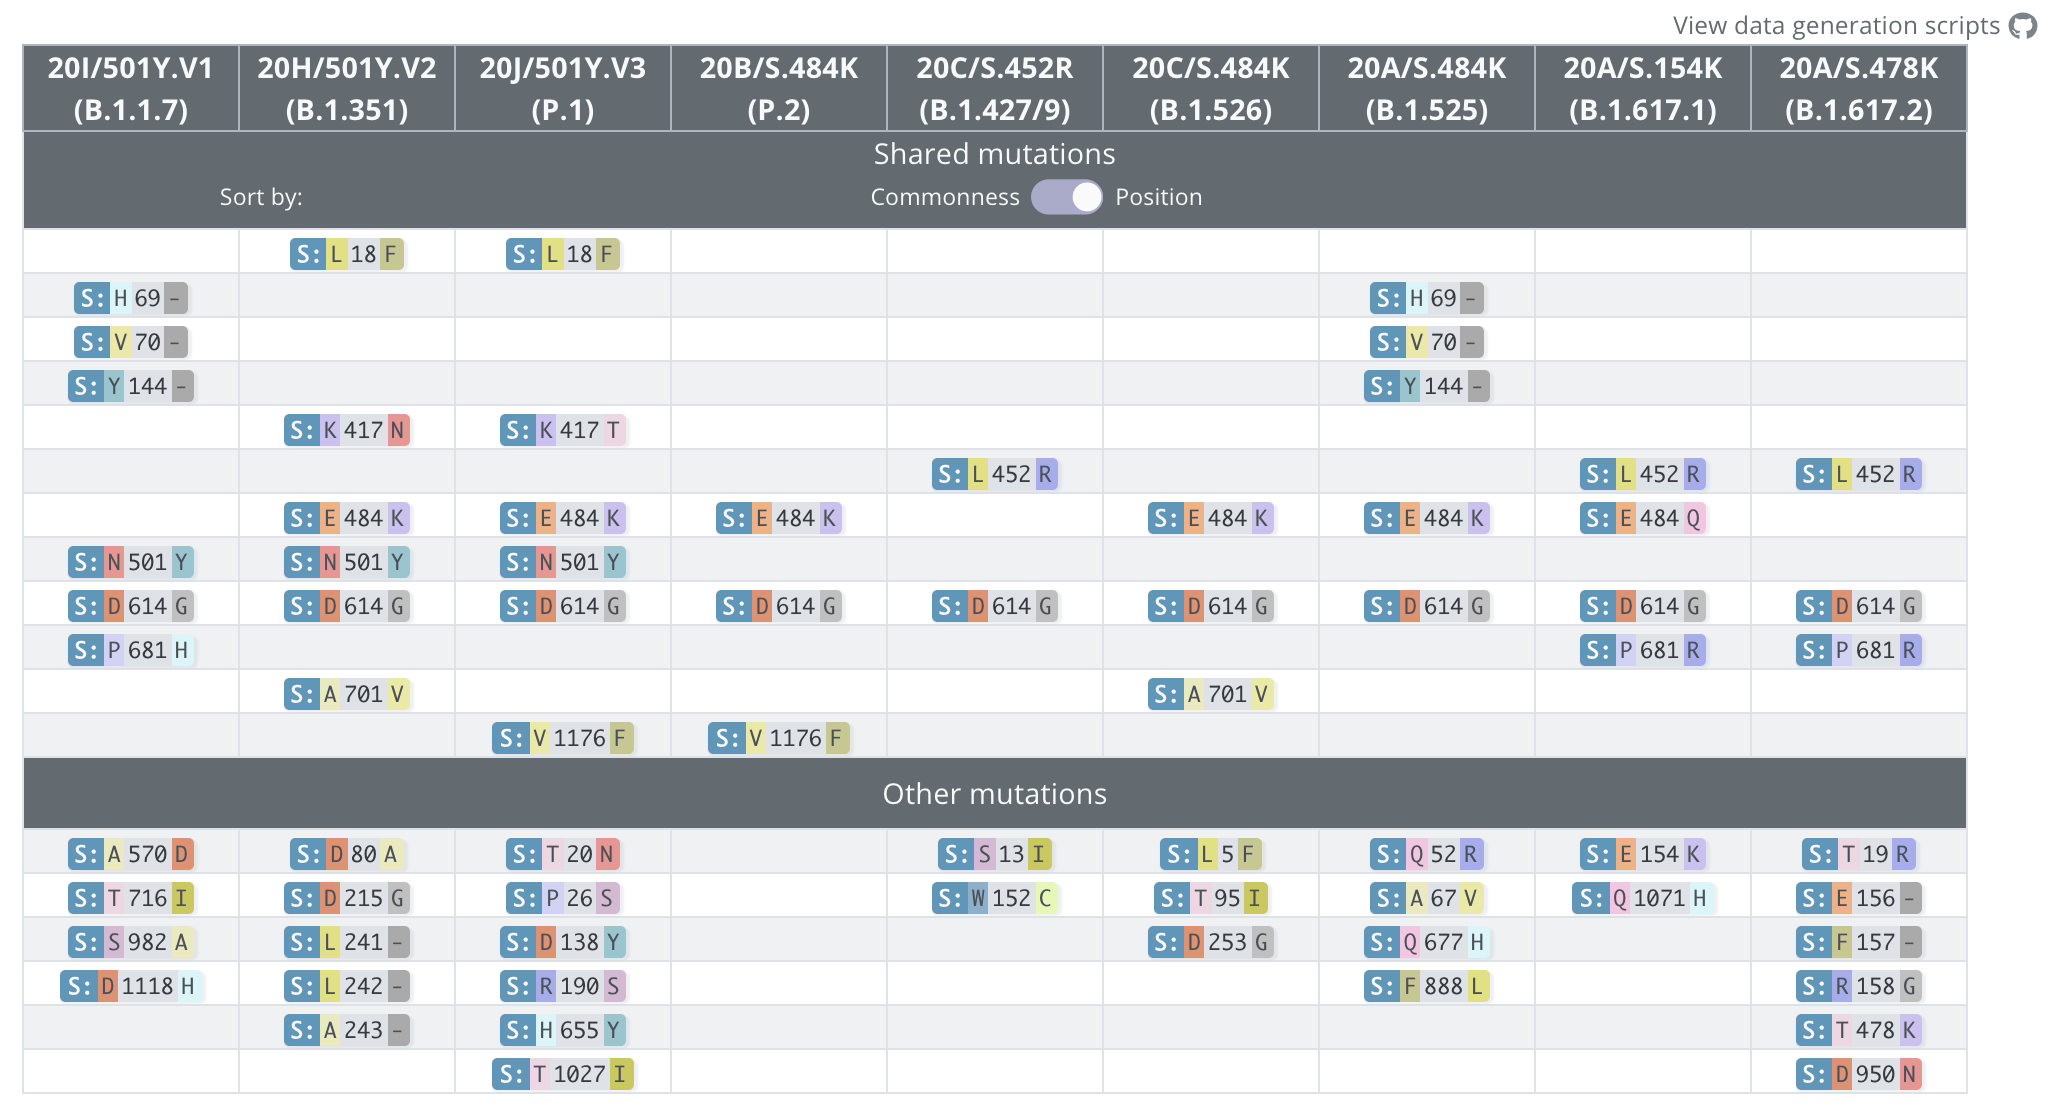